In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.model_selection import train_test_split
sys.path.append('../../')
import Constants as c
import Utilities as utils
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn import metrics
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
# file = "../../output/linux_version_metrics.csv"
file = "../../output/linux_version_metrics_major_versions.csv"
df = pd.read_csv(file)

df["E_Line"] = df["E_Line"].astype(str).astype(int)
df["E_Module"] = df["E_Module"].astype(str).astype(int)
df = df.rename(columns={"T_Line": "T_Line_Original", "T_Module": "T_Module_Original"})
df["T_Line"] = df["T_Line_Original"].shift()
df["T_Module"] = df["T_Module_Original"].shift()
df = df[[c.VERSION, c.NT, c.NO, "E_Line", "E_Module", c.T_LINE, c.T_MODULE]]

if df.isna().values.any():
    df.fillna(0, inplace=True)

# df = df.apply(lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) else x)
df.replace([np.inf, -np.inf], 0, inplace=True)
# df.replace(0, 1, inplace=True)
print(len(df))

76


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae05750e10>,
      dtype=object)

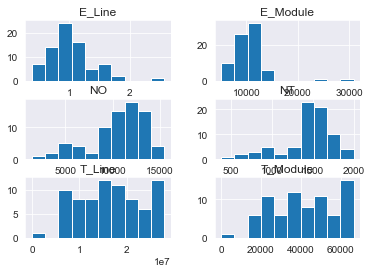

In [4]:
df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae0781af10>,
      dtype=object)

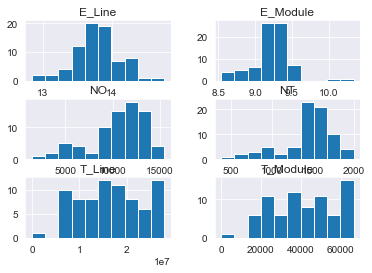

In [5]:
df["E_Line"] = utils.log_transform(df, "E_Line")
df["E_Module"] = utils.log_transform(df, "E_Module")
df.hist()

In [6]:
# print out a correlation matrix of our data frame
corr = df.corr(method="pearson")

# display it
display(corr)

,NT,NO,E_Line,E_Module,T_Line,T_Module
NT,1.000000,0.802101,0.703684,0.675682,0.500122,0.502389
NO,0.802101,1.000000,0.510963,0.801288,0.879057,0.884582
E_Line,0.703684,0.510963,1.000000,0.574472,0.259619,0.257326
E_Module,0.675682,0.801288,0.574472,1.000000,0.723415,0.720389
T_Line,0.500122,0.879057,0.259619,0.723415,1.000000,0.998781
T_Module,0.502389,0.884582,0.257326,0.720389,0.998781,1.000000


Text(0.5, 1.0, 'Correlation Plot - Linux Project')

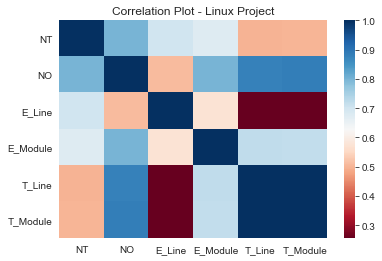

In [43]:
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
ax.set_title('Correlation Plot - Linux Project')

Text(0.5, 1.0, 'NT vs. E_Line - Linux')

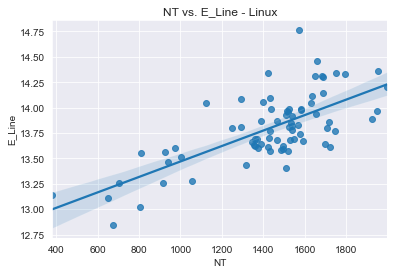

In [8]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Line", data=df)
plt.title('NT vs. E_Line - {0}'.format("Linux"))

Text(0.5, 1.0, 'NO vs. E_Line - Linux')

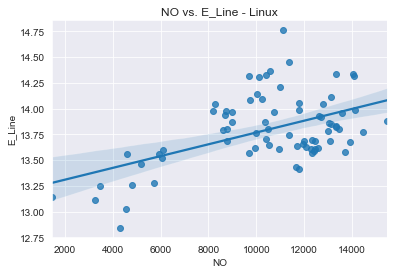

In [37]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NO, y="E_Line", data=df)
plt.title('NO vs. E_Line - {0}'.format("Linux"))

Text(0.5, 1.0, 'NT vs. E_Module - Linux')

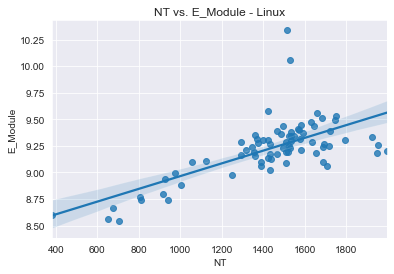

In [38]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Module", data=df)
plt.title('NT vs. E_Module - {0}'.format("Linux"))

Text(0.5, 1.0, 'NO vs. E_Module - Linux')

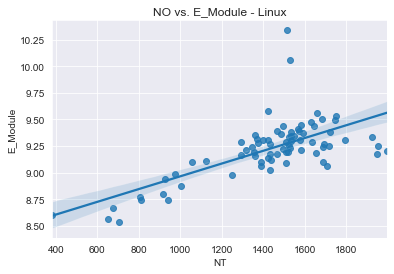

In [39]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Module", data=df)
plt.title('NO vs. E_Module - {0}'.format("Linux"))

Text(0.5, 1.0, 'T_MODULE vs. E_MODULE - Linux')

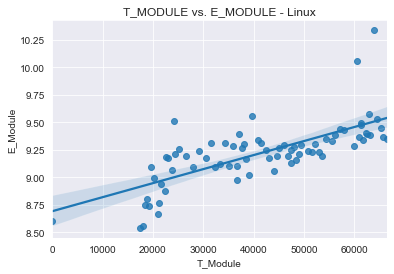

In [40]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.T_MODULE, y="E_Module", data=df)
plt.title('T_MODULE vs. E_MODULE - {0}'.format("Linux"))

In [9]:
# Let's create multiple regression
X = df[[c.NT, c.NO]]
Y = df['E_Line']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.876, test_size=0.124, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

OLS Regression Results                                
Dep. Variable:                 E_Line   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              731.1
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                    8.35e-45
Time:                        10:02:32   Log-Likelihood:                         -162.25
No. Observations:                  66   AIC:                                      328.5
Df Residuals:                      64   BIC:                                      332.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [10]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,NT,NO
vif,34.122913,34.122913


In [11]:
model.resid.mean()

0.6266525297932871

In [12]:
print("MAE: {0}".format(metrics.mean_absolute_error(y_test, predictions)))

MAE: 1.4529219830509361


Text(0.5, 1.0, 'E_Line Homoscedasticity')

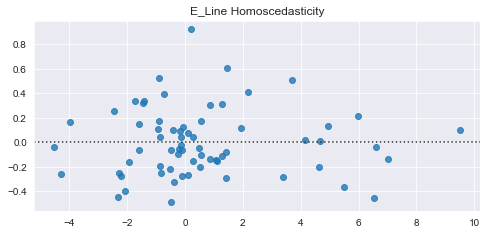

In [13]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = model.fittedvalues.copy()
true_val = y_train
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)
plt.title('E_Line Homoscedasticity')

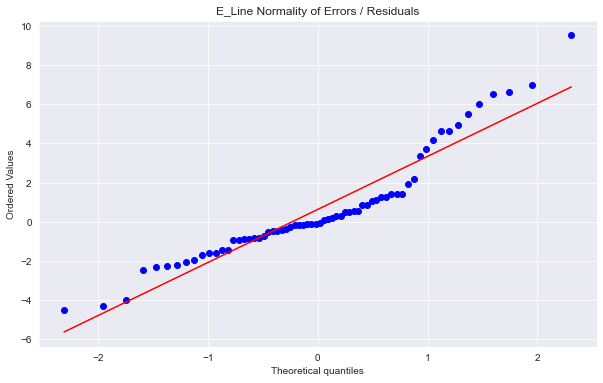

In [14]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Line Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Line Normality of Errors / Residuals')

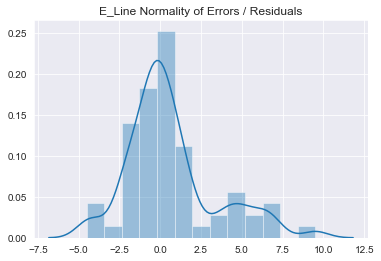

In [15]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Line Normality of Errors / Residuals')

In [16]:
results = utils.create_percent_error_df(y_test, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
52,13.62,13.68,0.05,0.00,0
57,13.88,17.65,3.76,0.27,1
22,13.69,12.76,0.93,0.07,2
75,13.69,12.34,1.35,0.10,3
28,13.79,11.58,2.21,0.16,4
26,13.87,12.89,0.98,0.07,5
71,13.96,13.80,0.15,0.01,6
54,13.68,13.96,0.28,0.02,7
34,13.57,13.27,0.30,0.02,8
7,13.60,9.09,4.51,0.33,9


In [17]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 80.00%
PRED (50): 100.00%


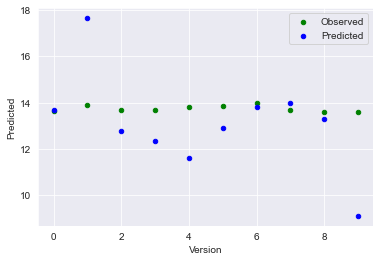

In [18]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

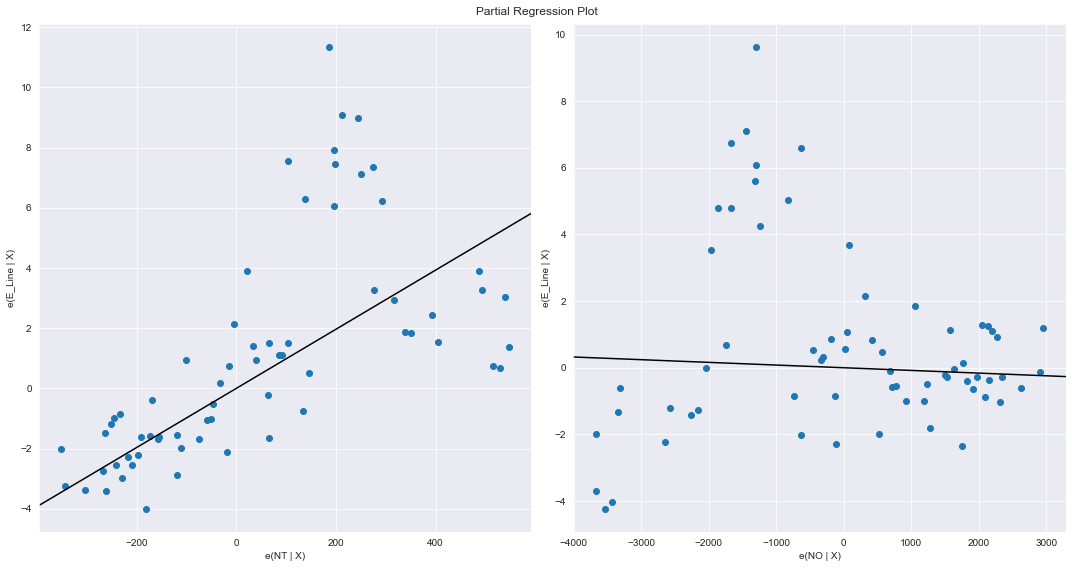

In [19]:
partialRegPlot = plt.figure(figsize=(15,8))
partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

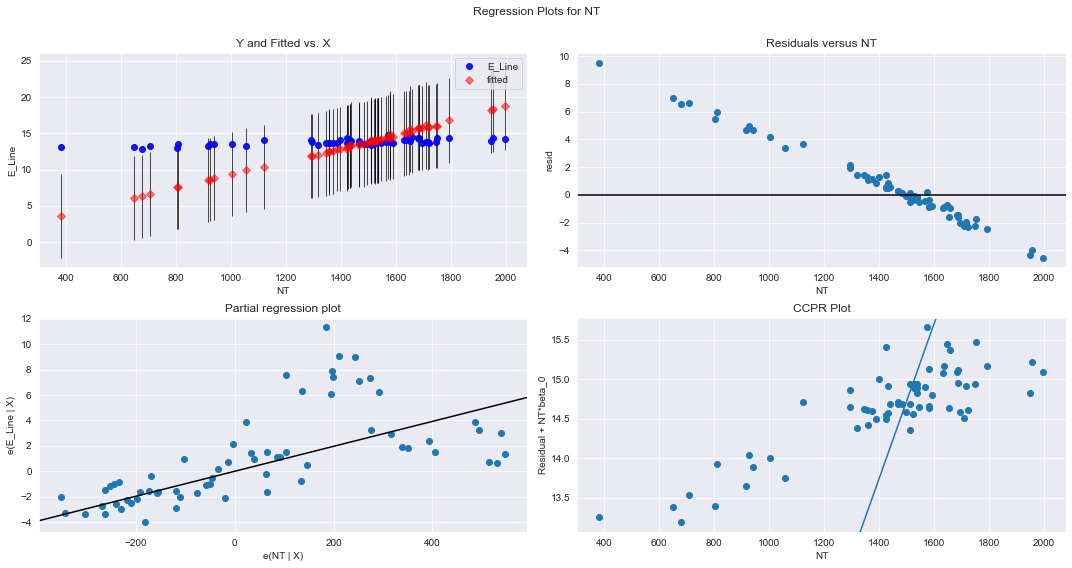

In [20]:
regPlotNC = plt.figure(figsize=(15,8))
regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, "NT", fig=regPlotNC)

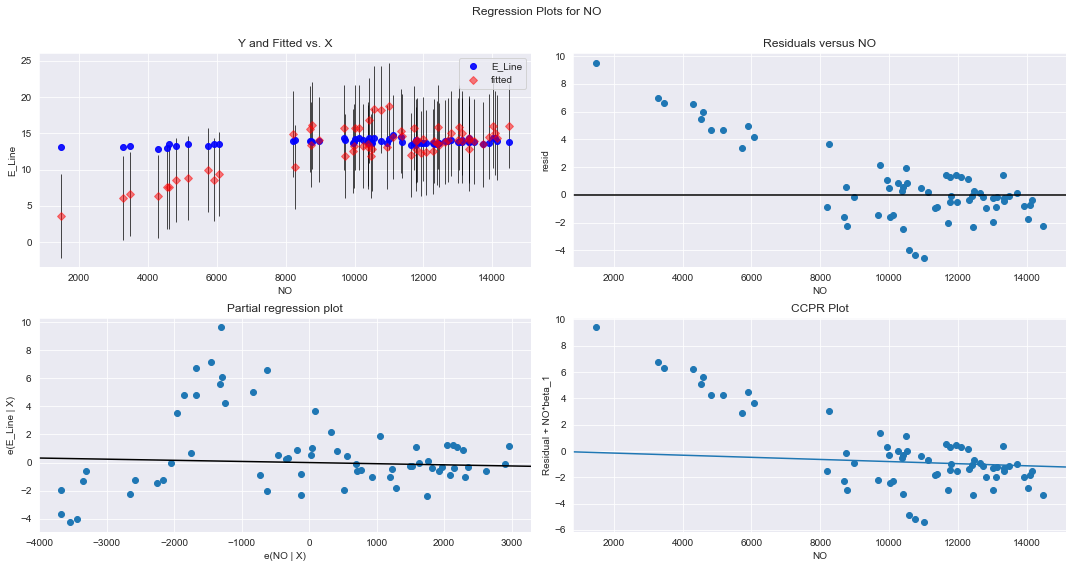

In [21]:
regPlotNO = plt.figure(figsize=(15,8))
regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, "NO", fig=regPlotNO)

In [22]:
# df.plot.scatter(x=c.NT, y='E_Module', c='red')
# df.plot.scatter(x=c.NO, y='E_Module', c='green')
# df.plot.scatter(x=c.T_MODULE, y='E_Module', c='orange')
# df.plot.scatter(x=c.T_LINE, y='E_Module', c='purple')

In [23]:
# Let's create multiple regression
X = df[[c.NT, c.NO, c.T_MODULE]]
Y = df['E_Module']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.876, test_size=0.124, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)

OLS Regression Results                                
Dep. Variable:               E_Module   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              578.2
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                    9.02e-46
Time:                        10:02:48   Log-Likelihood:                         -129.64
No. Observations:                  66   AIC:                                      265.3
Df Residuals:                      63   BIC:                                      271.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [24]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,NT,NO,T_Module
vif,70.529278,230.937476,67.423833


In [25]:
model.resid.mean()

0.3546773823197697

In [26]:
print("MAE: {0}".format(metrics.mean_absolute_error(y_test, predictions)))

MAE: 0.7798311041785824


Text(0.5, 1.0, 'E_Module Homoscedasticity')

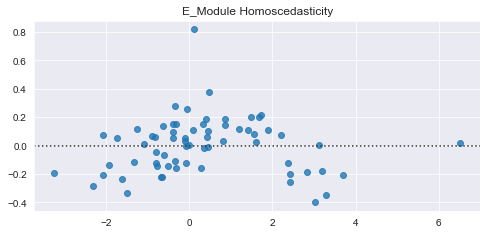

In [27]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = model.fittedvalues.copy()
true_val = y_train
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)
plt.title('E_Module Homoscedasticity')

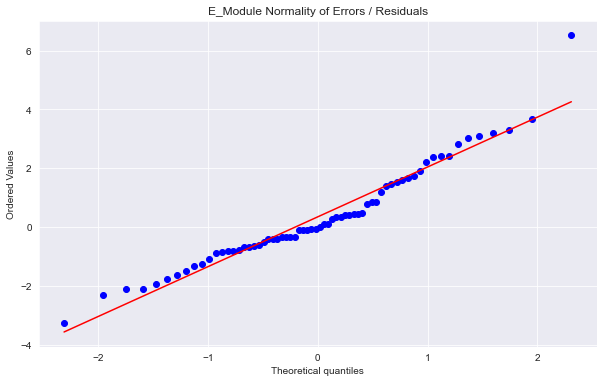

In [28]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Module Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Module Normality of Errors / Residuals')

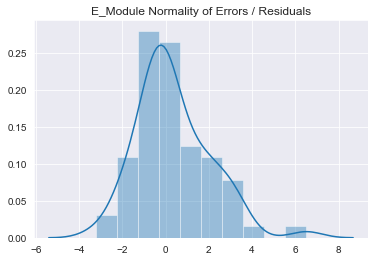

In [29]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Module Normality of Errors / Residuals')

In [30]:
results = utils.create_percent_error_df(y_test, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
52,9.23,8.90,0.33,0.04,0
57,9.33,10.65,1.32,0.14,1
22,9.32,8.58,0.74,0.08,2
75,9.35,9.89,0.54,0.06,3
28,8.98,8.33,0.64,0.07,4
26,9.10,8.99,0.12,0.01,5
71,10.34,9.84,0.50,0.05,6
54,9.23,8.92,0.31,0.03,7
34,9.02,9.27,0.25,0.03,8
7,8.99,5.93,3.06,0.34,9


In [31]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 90.00%
PRED (50): 100.00%


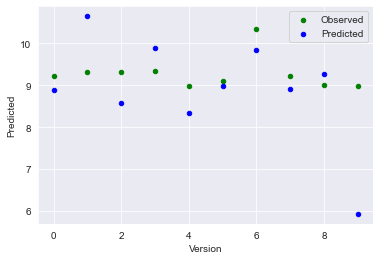

In [32]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

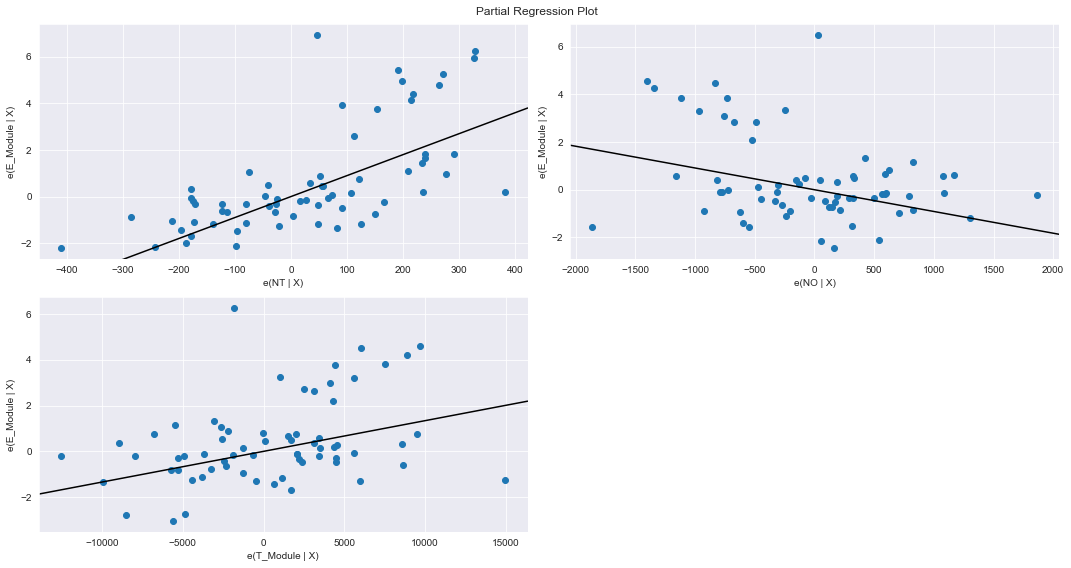

In [33]:
partialRegPlot = plt.figure(figsize=(15,8))
partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

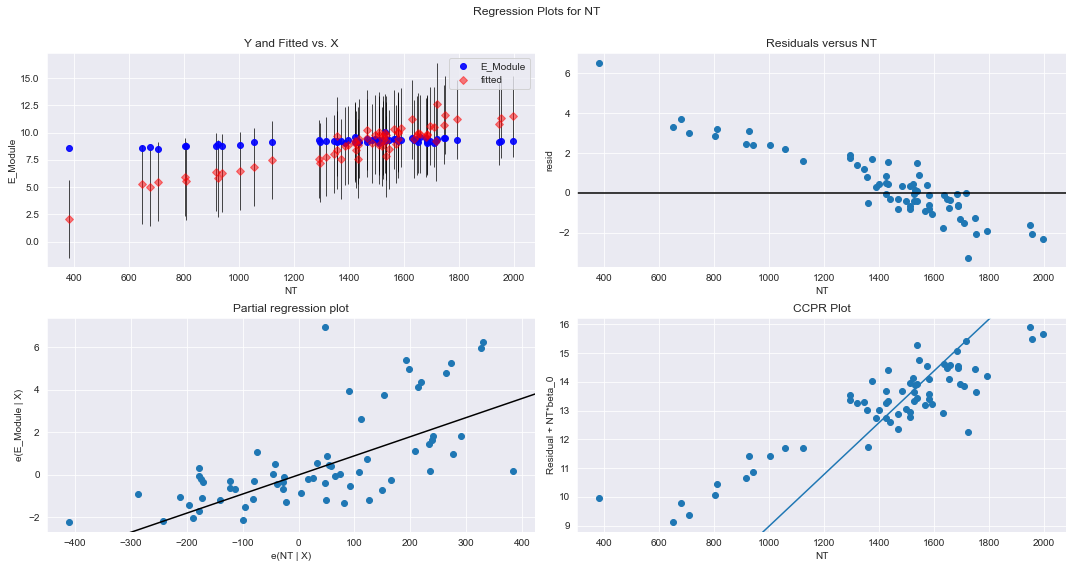

In [34]:
regPlotNC = plt.figure(figsize=(15,8))
regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, "NT", fig=regPlotNC)

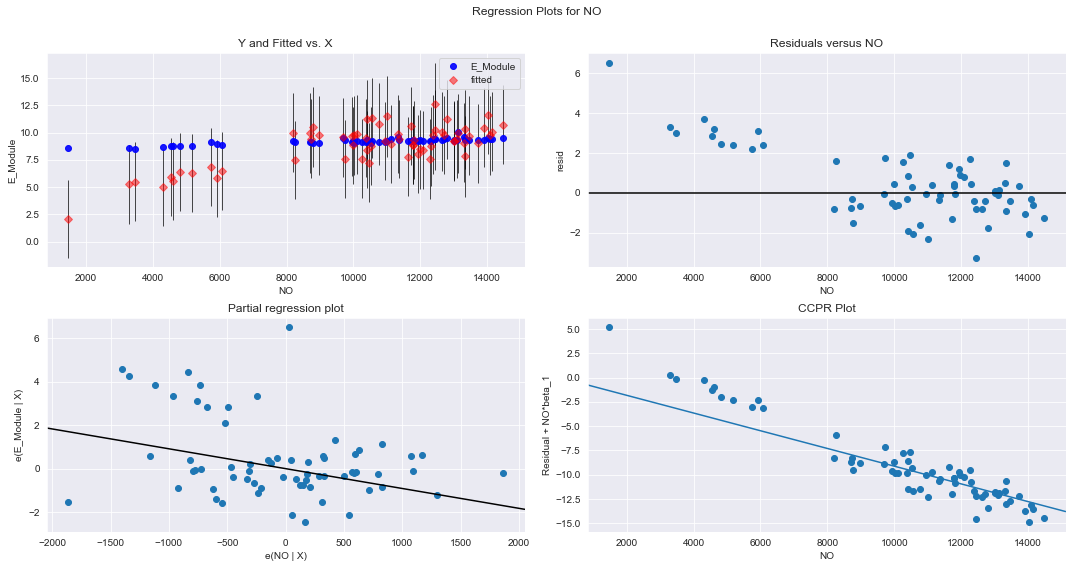

In [35]:
regPlotNO = plt.figure(figsize=(15,8))
regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, "NO", fig=regPlotNO)

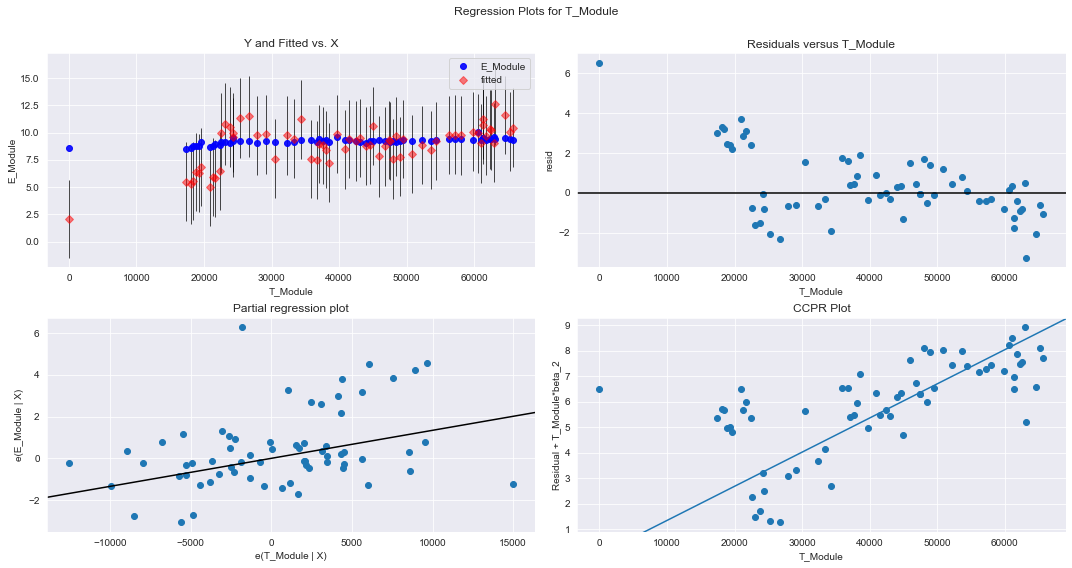

In [36]:
regPlotNO = plt.figure(figsize=(15,8))
regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.T_MODULE, fig=regPlotNO)